# Installing New Libraries

In [3]:
!pip install SimpleITK 

# Importing needed libraries

In [1]:
from glob import glob
import os
import matplotlib.pyplot as plt
import sys
#from google.colab import drive
import SimpleITK as sitk
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from ANTsPy import ants
import pandas as pd
import nibabel as nib
import seaborn as sns
import numpy as np

%matplotlib inline


# Google Drive configurations

In [3]:
drive.mount('/content/drive',force_remount = True)

FOLDERNAME = 'Tesis'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Mounted at /content/drive


### Disclaimer: Declaring the sys pathway isn't necessary if the working directory is the same as the root directory, which is true for all local runs

# Train Dataset

## Frames

### Run this cell in case it's a colab

In [ ]:
#generate a root path
root_path = '/content/drive/MyDrive'
#join with the dataset path
my_data_path = f'{root_path}/Tesis/Dataset' # change accordingly
#generate a sorted list of the patients' paths only the first frames
patient_dirs_tr = sorted(glob(f'{my_data_path}/Train/*/*[0-9].nii*'))
#check the number of paths
print(len(patient_dirs_tr))

### Run this cell instead of the previous one for a local directory 

It is looking for all .nii files in the 'database/training/' directory through the reg in the glob func()

In [2]:
#generate a data path
my_data_path = 'database' # change accordingly
#generate a sorted list of the patients' paths only the first frames
patient_dirs_tr = sorted(glob(f'{my_data_path}/training/*/*[0-9].nii*'))
#check the number of paths
print(len(patient_dirs_tr))

200


## Metadata

NiftiImageIO (0x2ce14d540): database/training/patient001/patient001_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e7117710): database/training/patient001/patient001_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e5b3b180): database/training/patient001/patient001_frame12.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c1f61b80): database/training/patient001/patient001_frame12.nii.gz has unexpected scales in sform

NiftiImageIO (0x2ce14b7b0): database/training/patient002/patient002_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2cedcbaf0): database/training/patient002/patient002_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2cedcbaf0): database/training/patient002/patient002_frame12.nii.gz has unexpected scales in sform

NiftiImageIO (0x2cedcbaf0): database/training/patient002/patient002_frame12.nii.gz has unexpected scales in sform

NiftiImageIO (0x2cedcbaf0): database/training/patient003/patient003_frame01.nii.

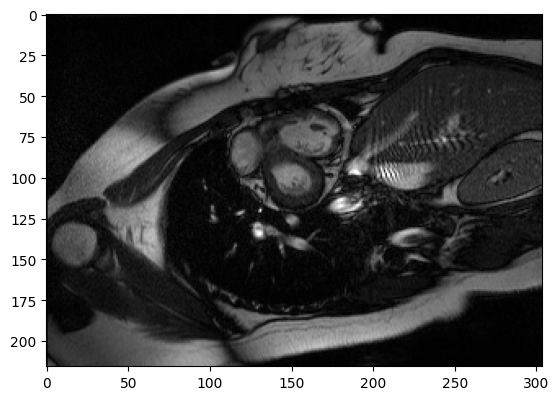

In [3]:
def metadata(paths, name):
  '''
  Captures the metadata from images and store in csv file
  Arguments:
  paths (list): list of paths where the images are stored
  name (string): name of the csv file that is going to be safe
  '''
  #dictionary for spacing
  spacing_tr = []
  dimension_tr = []
  max_tr = []
  min_tr = []
  std_tr = []
  x = []
  y = []
  z = []
  sp_x = []
  sp_y = []
  sp_z = []

  patient_name_tr = []

  for patient in paths:
      #read image
      aimg = ants.image_read(patient)

      #append in list  spacing
      spacing_tr.append(aimg.spacing)

      #append in list dimension
      dimension_tr.append(aimg.shape)

      #append in list max
      max_tr.append(aimg.max())

      #append in list min
      min_tr.append(aimg.min())

      #append in list std
      std_tr.append(aimg.std())

      x.append(aimg.shape[0])
      y.append(aimg.shape[1])
      z.append(aimg.shape[2])

      sp_x.append(aimg.spacing[0])
      sp_y.append(aimg.spacing[1])
      sp_z.append(aimg.spacing[2])

  metadata_df = pd.DataFrame({
      "patient": range(1, len(paths)+1), "dimension":dimension_tr,"spacing":spacing_tr,
      "maximum": max_tr, "minimum": min_tr, "std": std_tr, "x":x, "y":y,"z":z,
      "x_sp":sp_x, "y_sp":sp_y, "z_sp":sp_z
  })

  metadata_df.head()

  metadata_df.to_csv(f"{name}_metadata.csv")

  plt.imshow(aimg[:,:,0],cmap = 'gray')
  plt.show()

  return metadata_df

df_train = metadata(patient_dirs_tr, "Train_Frames")


In [4]:
df_train["dimension"]

0      (216, 256, 10)
1      (216, 256, 10)
2      (232, 256, 10)
3      (232, 256, 10)
4      (256, 256, 10)
            ...      
195     (216, 256, 7)
196    (154, 224, 16)
197    (154, 224, 16)
198     (216, 304, 8)
199     (216, 304, 8)
Name: dimension, Length: 200, dtype: object

## Image spatial (shape)

Text(0.5, 1.0, 'Axial')

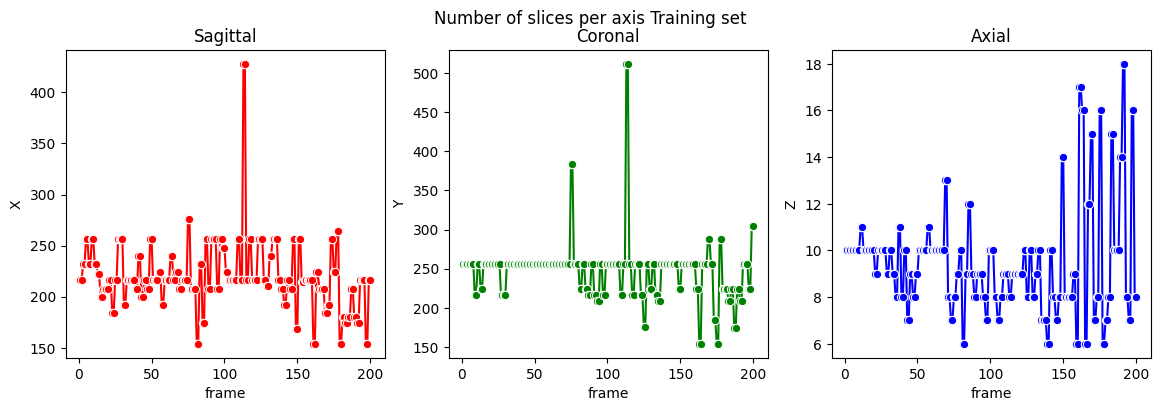

In [5]:
patient_ids = []
xs = []
ys = []
zs = []
for nifti in patient_dirs_tr:
    patient_ids.append(nifti.split('/')[-2])
    scan = nib.load(nifti)
    scanArray = scan.get_fdata()
    x, y, z = scanArray.shape
    xs.append(x)
    ys.append(y)
    zs.append(z)

fig, axs = plt.subplots(ncols=3,figsize=(14,4))
fig.suptitle('Number of slices per axis Training set')
df_x = pd.DataFrame({'frame': range(1,len(patient_dirs_tr)+1), 'X': xs})
df_y = pd.DataFrame({'frame': range(1,len(patient_dirs_tr)+1), 'Y': ys})
df_z = pd.DataFrame({'frame': range(1,len(patient_dirs_tr)+1), 'Z': zs})

sns.lineplot(df_x, x='frame', y='X', ax=axs[0], color='r', marker='o')
sns.lineplot(df_y, x='frame', y='Y',ax=axs[1], color='g', marker='o')
sns.lineplot(df_z, x='frame', y='Z',ax=axs[2], color='b', marker='o')

axs[0].set_title('Sagittal')
axs[1].set_title('Coronal')
axs[2].set_title('Axial')

## Preprocessing

In [6]:
from CardiacImagePreprocessing import *


In [7]:
new_size = [256,256,10]
new_spacing = [1.5625,1.5625,10.0]
transformed_dataset_tr = CardiacImageDataset(image_paths = patient_dirs_tr,
                                          transform = transforms.Compose(
                                              [
                                                Rescale(new_size,new_spacing, method = "Linear"),
                                                Outliers(),Normalization()
                                              ]
                                          ))


In [8]:
matrix_tr = np.zeros((len(patient_dirs_tr)*new_size[2],1,new_size[0],new_size[1]))

for i, sample in enumerate(transformed_dataset_tr):
  image = sample["image"]
  slices = image.shape[2]  # Get the number of slices in the image

  # Iterate through the slices and copy them to the matrix
  for slice_idx in range(slices):
      # Copy the slice from the image to the corresponding position in the matrix
      matrix_tr[i * slices + slice_idx,:, :, :] = image[:,:,slice_idx]



NiftiImageIO (0x2e5b3b180): database/training/patient001/patient001_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e5b3b180): database/training/patient001/patient001_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e7117710): database/training/patient001/patient001_frame12.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e7117710): database/training/patient001/patient001_frame12.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c7d98650): database/training/patient002/patient002_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c7d98650): database/training/patient002/patient002_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2ca9ef760): database/training/patient002/patient002_frame12.nii.gz has unexpected scales in sform

NiftiImageIO (0x2ca9ef760): database/training/patient002/patient002_frame12.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c1f637a0): database/training/patient003/patient003_frame01.nii.

In [9]:
#save the matrix
np.save("Train_frames.npy", matrix_tr)

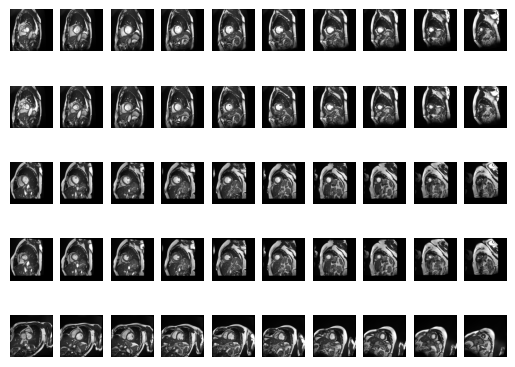

In [10]:
for i in range(50):
    plt.subplot(5, 10, i + 1)  # Create a grid of 5x10 subplots
    plt.imshow(matrix_tr[i,0], cmap='gray')
    plt.axis('off')

plt.show()

## Ground Truth

In [12]:
ground_truth_tr = sorted(glob(f'{my_data_path}/training/*/*gt.nii*'))
len(ground_truth_tr)

200

NiftiImageIO (0x2e716f580): database/training/patient001/patient001_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e5b8cd00): database/training/patient001/patient001_frame01_gt.nii.gz has unexpected scales in sform



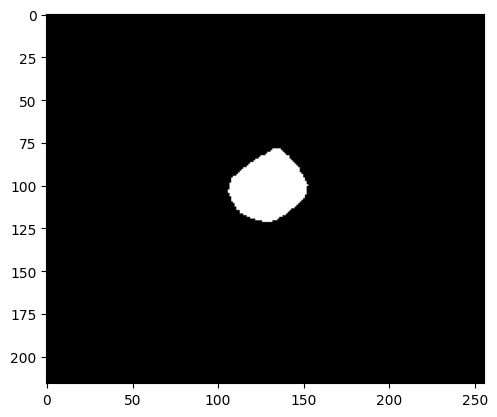

In [13]:
image = ants.image_read(ground_truth_tr[0])
plt.imshow(image[:,:,1] == 3, cmap = 'gray')

In [14]:
new_size = [256,256,10]
new_spacing = [1.5625,1.5625,10.0]
transformed_gt_tr = CardiacImageDataset(image_paths = ground_truth_tr,
                                          transform = transforms.Compose(
                                              [
                                                Rescale(new_size,new_spacing, method = "KNearestNeightbor")
                                              ]
                                          ))

In [15]:
matrix_gt_tr = np.zeros((len(ground_truth_tr)*new_size[2],4, new_size[0],new_size[1]))

for i, sample in enumerate(transformed_gt_tr):
  image = sample["image"]
  slices = image.shape[2]  # Get the number of slices in the image

  # Iterate through the slices and copy them to the matrix
  for slice_idx in range(slices):

    for label in range(4):
      # Copy the slice from the image to the corresponding position in the matrix
      matrix_gt_tr[i * slices + slice_idx, label, :, :] = image[:, :,slice_idx] == label



NiftiImageIO (0x2c7dbac10): database/training/patient001/patient001_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c7dbac10): database/training/patient001/patient001_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2cedf1d70): database/training/patient001/patient001_frame12_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2cedf1d70): database/training/patient001/patient001_frame12_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e7543570): database/training/patient002/patient002_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e7543570): database/training/patient002/patient002_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2cedf1c80): database/training/patient002/patient002_frame12_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2cedf1c80): database/training/patient002/patient002_frame12_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2cedf1c80): database/training/patient003

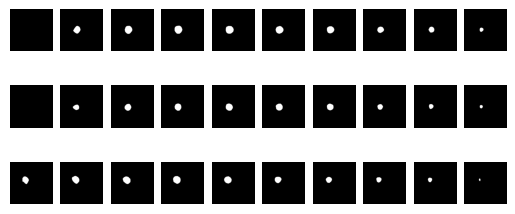

In [16]:
for i in range(30):
    plt.subplot(5, 10, i + 1)  # Create a grid of 5x10 subplots
    plt.imshow(matrix_gt_tr[i, 3], cmap='gray')
    plt.axis('off')

plt.show()

In [17]:
#save the matrix
np.save("Train_gt.npy", matrix_gt_tr)

# Validation Dataset

## Frames

In [19]:
#generate a sorted list of the patients' paths only the first frames
patient_dirs_vt = sorted(glob(f'{my_data_path}/validating/*/*[0-9].nii*'))
#check the number of paths
print(len(patient_dirs_vt))

100


## Metadata

NiftiImageIO (0x2cede3780): database/testing/patient101/patient101_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e7117710): database/testing/patient101/patient101_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e4886780): database/testing/patient101/patient101_frame14.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e7539ec0): database/testing/patient101/patient101_frame14.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50981b0): database/testing/patient102/patient102_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e3ff29e0): database/testing/patient102/patient102_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e7117710): database/testing/patient102/patient102_frame13.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e5b579c0): database/testing/patient102/patient102_frame13.nii.gz has unexpected scales in sform

NiftiImageIO (0x2cede5fb0): database/testing/patient103/patient103_frame01.nii.gz has un

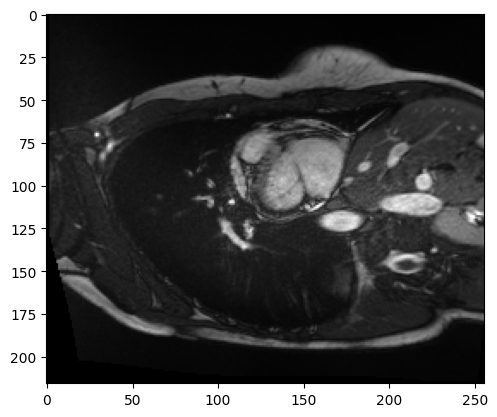

In [20]:
df_val = metadata(patient_dirs_vt, "Validation_Frames")

In [21]:
print(df_val["x"].mode()[0])
print(df_val["y"].mode()[0])
print(df_val["z"].mode()[0])

216
256
10


## Image spatial (shape)

Text(0.5, 1.0, 'Axial')

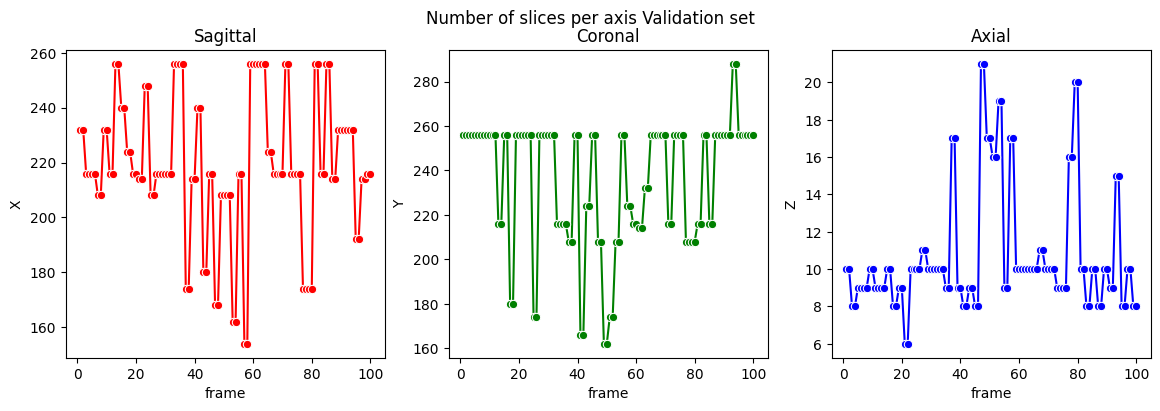

In [22]:
patient_ids = []
xs = []
ys = []
zs = []
for nifti in patient_dirs_vt:
    patient_ids.append(nifti.split('/')[-2])
    scan = nib.load(nifti)
    scanArray = scan.get_fdata()
    x, y, z = scanArray.shape
    xs.append(x)
    ys.append(y)
    zs.append(z)

fig, axs = plt.subplots(ncols=3,figsize=(14,4))
fig.suptitle('Number of slices per axis Validation set')
df_x = pd.DataFrame({'frame': range(1,len(patient_dirs_vt)+1), 'X': xs})
df_y = pd.DataFrame({'frame': range(1,len(patient_dirs_vt)+1), 'Y': ys})
df_z = pd.DataFrame({'frame': range(1,len(patient_dirs_vt)+1), 'Z': zs})

sns.lineplot(df_x, x='frame', y='X', ax=axs[0], color='r', marker='o')
sns.lineplot(df_y, x='frame', y='Y',ax=axs[1], color='g', marker='o')
sns.lineplot(df_z, x='frame', y='Z',ax=axs[2], color='b', marker='o')

axs[0].set_title('Sagittal')
axs[1].set_title('Coronal')
axs[2].set_title('Axial')

## Preprocessing

In [23]:
new_size = [256,256,10]
new_spacing = [1.5625,1.5625,10.0]
transformed_dataset_vt = CardiacImageDataset(image_paths = patient_dirs_vt,
                                          transform = transforms.Compose(
                                              [
                                                Rescale(new_size,new_spacing, method = "Linear"),
                                                Outliers(),Normalization()
                                              ]
                                          ))

In [24]:
matrix_vt = np.zeros((len(patient_dirs_vt)*new_size[2],1,new_size[0],new_size[1]))

for i, sample in enumerate(transformed_dataset_vt):
  image = sample["image"]
  slices = image.shape[2]  # Get the number of slices in the image

  # Iterate through the slices and copy them to the matrix
  for slice_idx in range(slices):
      # Copy the slice from the image to the corresponding position in the matrix
      matrix_vt[i * slices + slice_idx,:, :, :] = image[:,:,slice_idx]

NiftiImageIO (0x2e5b8df20): database/testing/patient101/patient101_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e5b8df20): database/testing/patient101/patient101_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e717cbc0): database/testing/patient101/patient101_frame14.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e717cbc0): database/testing/patient101/patient101_frame14.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c0f1f500): database/testing/patient102/patient102_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c0f1f500): database/testing/patient102/patient102_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c0f1f520): database/testing/patient102/patient102_frame13.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c0f1f520): database/testing/patient102/patient102_frame13.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c0f20960): database/testing/patient103/patient103_frame01.nii.gz has un

In [25]:
#save the matrix
np.save("Validation_frames.npy", matrix_vt)

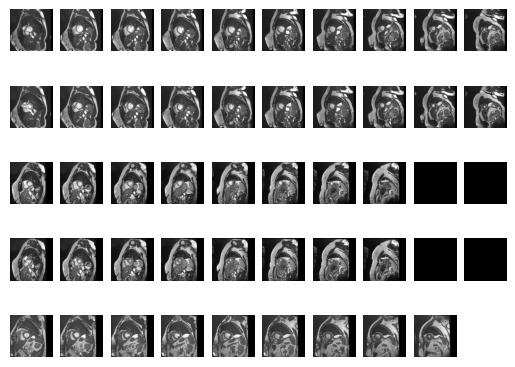

In [26]:
for i in range(49):
    plt.subplot(5, 10, i + 1)  # Create a grid of 5x10 subplots
    plt.imshow(matrix_vt[i,0], cmap='gray')
    plt.axis('off')

plt.show()

## Ground Truth

In [28]:
ground_truth_vt = sorted(glob(f'{my_data_path}/validating/*/*gt.nii*'))
len(ground_truth_vt)

100

In [29]:
new_size = [256,256,10]
new_spacing = [1.5625,1.5625,10.0]
transformed_gt_vt = CardiacImageDataset(image_paths = ground_truth_vt,
                                          transform = transforms.Compose(
                                              [
                                                Rescale(new_size,new_spacing, method = "KNearestNeightbor")
                                              ]
                                          ))

In [30]:
matrix_gt_vt = np.zeros((len(ground_truth_vt)*new_size[2],4, new_size[0],new_size[1]))

for i, sample in enumerate(transformed_gt_vt):
  image = sample["image"]
  slices = image.shape[2]  # Get the number of slices in the image

  # Iterate through the slices and copy them to the matrix
  for slice_idx in range(slices):

    for label in range(4):
      # Copy the slice from the image to the corresponding position in the matrix
      matrix_gt_vt[i * slices + slice_idx, label, :, :] = image[:, :,slice_idx,] == label

NiftiImageIO (0x2e753f110): database/testing/patient101/patient101_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e753f110): database/testing/patient101/patient101_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50b6960): database/testing/patient101/patient101_frame14_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50b6960): database/testing/patient101/patient101_frame14_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e71749b0): database/testing/patient102/patient102_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e71749b0): database/testing/patient102/patient102_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50b6960): database/testing/patient102/patient102_frame13_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50b6960): database/testing/patient102/patient102_frame13_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e5bb3350): database/testing/patient103/patient1

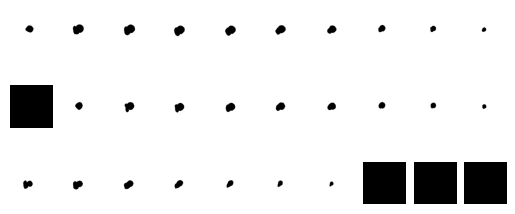

In [31]:
for i in range(30):
    plt.subplot(5, 10, i + 1)  # Create a grid of 5x10 subplots
    plt.imshow(matrix_gt_vt[i, 0], cmap='gray')
    plt.axis('off')

plt.show()

In [32]:
#save the matrix
np.save("Validation_gt.npy", matrix_gt_vt)

# Test Dataset

## Frames

In [33]:
#generate a sorted list of the patients' paths only the first frames
patient_dirs_ts = sorted(glob(f'{my_data_path}/testing/*/*[0-9].nii*'))
#check the number of paths
print(len(patient_dirs_ts))

100


## Metadata

NiftiImageIO (0x2e7199790): database/testing/patient101/patient101_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50bd330): database/testing/patient101/patient101_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e71995c0): database/testing/patient101/patient101_frame14.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50bd140): database/testing/patient101/patient101_frame14.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e71997d0): database/testing/patient102/patient102_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50bd140): database/testing/patient102/patient102_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e71997f0): database/testing/patient102/patient102_frame13.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50bd140): database/testing/patient102/patient102_frame13.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50bcdb0): database/testing/patient103/patient103_frame01.nii.gz has un

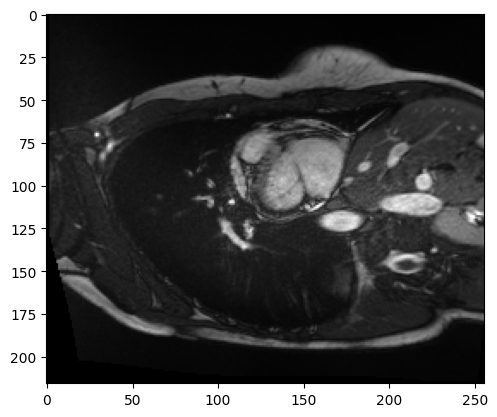

In [34]:
df_test = metadata(patient_dirs_ts, "Test_Frames")

In [35]:
print(df_test["x"].mode()[0])
print(df_test["y"].mode()[0])
print(df_test["z"].mode()[0])

216
256
10


## Image Spatial(shape)

Text(0.5, 1.0, 'Axial')

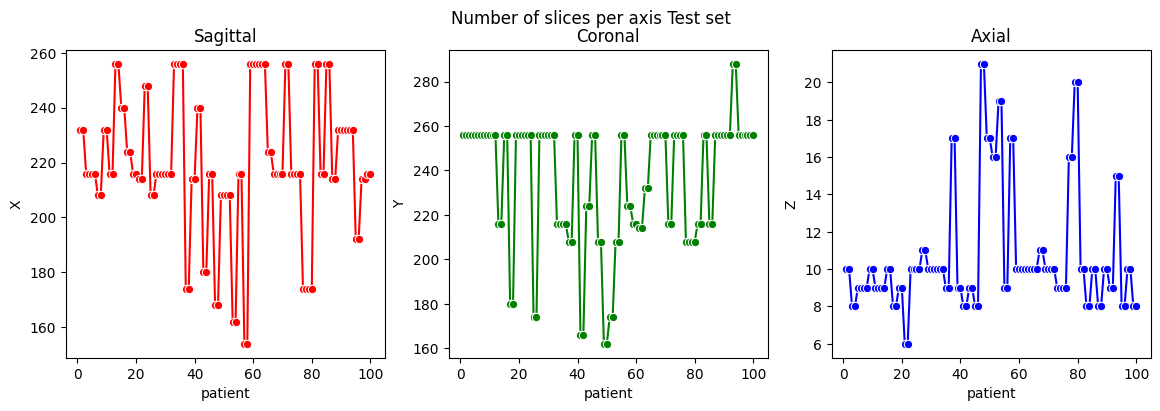

In [36]:
patient_ids = []
xs = []
ys = []
zs = []
for nifti in patient_dirs_ts:
    patient_ids.append(nifti.split('/')[-2])
    scan = nib.load(nifti)
    scanArray = scan.get_fdata()
    x, y, z = scanArray.shape
    xs.append(x)
    ys.append(y)
    zs.append(z)

fig, axs = plt.subplots(ncols=3,figsize=(14,4))
fig.suptitle('Number of slices per axis Test set')
df_x = pd.DataFrame({'patient': range(1,len(patient_dirs_ts)+1), 'X': xs})
df_y = pd.DataFrame({'patient': range(1,len(patient_dirs_ts)+1), 'Y': ys})
df_z = pd.DataFrame({'patient': range(1,len(patient_dirs_ts)+1), 'Z': zs})

sns.lineplot(df_x, x='patient', y='X', ax=axs[0], color='r', marker='o')
sns.lineplot(df_y, x='patient', y='Y',ax=axs[1], color='g', marker='o')
sns.lineplot(df_z, x='patient', y='Z',ax=axs[2], color='b', marker='o')

axs[0].set_title('Sagittal')
axs[1].set_title('Coronal')
axs[2].set_title('Axial')

## Preprocessing

In [37]:
new_size = [256,256,10]
new_spacing = [1.5625,1.5625,10.0]
transformed_dataset_ts = CardiacImageDataset(image_paths = patient_dirs_ts,
                                          transform = transforms.Compose(
                                              [
                                                Rescale(new_size,new_spacing, method = "Linear"),
                                                Outliers(),Normalization()
                                              ]
                                          ))


In [38]:
matrix_ts = np.zeros((len(patient_dirs_ts)*new_size[2],1,new_size[0],new_size[1]))

for i, sample in enumerate(transformed_dataset_ts):
  image = sample["image"]
  slices = image.shape[2]  # Get the number of slices in the image

  # Iterate through the slices and copy them to the matrix
  for slice_idx in range(slices):
      # Copy the slice from the image to the corresponding position in the matrix
      matrix_ts[i * slices + slice_idx,:, :, :] = image[:,:,slice_idx]



NiftiImageIO (0x2e719d7f0): database/testing/patient101/patient101_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e719d7f0): database/testing/patient101/patient101_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2f110f220): database/testing/patient101/patient101_frame14.nii.gz has unexpected scales in sform

NiftiImageIO (0x2f110f220): database/testing/patient101/patient101_frame14.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e719f8d0): database/testing/patient102/patient102_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e719f8d0): database/testing/patient102/patient102_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e719ef10): database/testing/patient102/patient102_frame13.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e719ef10): database/testing/patient102/patient102_frame13.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50c3110): database/testing/patient103/patient103_frame01.nii.gz has un

In [39]:
#save the matrix
np.save("Test_frames.npy", matrix_ts)

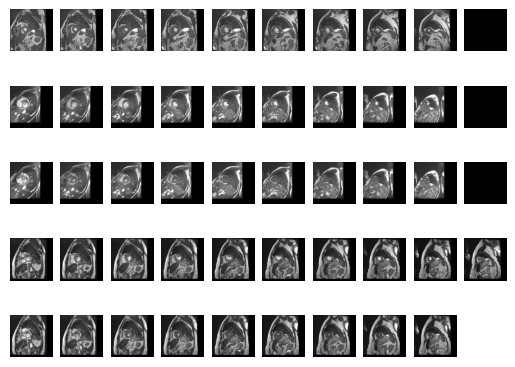

In [40]:
for i in range(49):
    plt.subplot(5, 10, i + 1)  # Create a grid of 5x10 subplots
    plt.imshow(matrix_ts[i+50,0], cmap='gray')
    plt.axis('off')

plt.show()

## Ground Truth

In [41]:
ground_truth_ts = sorted(glob(f'{my_data_path}/testing/*/*gt.nii*'))
len(ground_truth_ts)

100

In [42]:
new_size = [256,256,10]
new_spacing = [1.5625,1.5625,10.0]
transformed_gt_ts = CardiacImageDataset(image_paths = ground_truth_ts,
                                          transform = transforms.Compose(
                                              [
                                                Rescale(new_size,new_spacing, method = "KNearestNeightbor")
                                              ]
                                          ))

In [43]:
matrix_gt_ts = np.zeros((len(ground_truth_ts)*new_size[2],4, new_size[0],new_size[1]))

for i, sample in enumerate(transformed_gt_ts):
  image = sample["image"]
  slices = image.shape[2]  # Get the number of slices in the image

  # Iterate through the slices and copy them to the matrix
  for slice_idx in range(slices):

    for label in range(4):
      # Copy the slice from the image to the corresponding position in the matrix
      matrix_gt_ts[i * slices + slice_idx, label, :, :] = image[:, :,slice_idx] == label

NiftiImageIO (0x2e718cb00): database/testing/patient101/patient101_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e718cb00): database/testing/patient101/patient101_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50a9000): database/testing/patient101/patient101_frame14_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50a9000): database/testing/patient101/patient101_frame14_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e718c790): database/testing/patient102/patient102_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e718c790): database/testing/patient102/patient102_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e5b7c740): database/testing/patient102/patient102_frame13_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e5b7c740): database/testing/patient102/patient102_frame13_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e718c780): database/testing/patient103/patient1

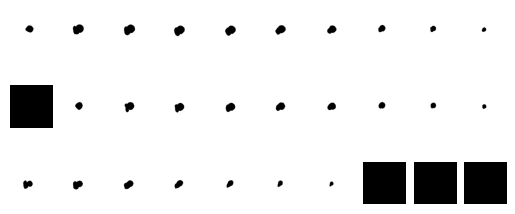

In [44]:
for i in range(30):
    plt.subplot(5, 10, i + 1)  # Create a grid of 5x10 subplots
    plt.imshow(matrix_gt_ts[i, 0], cmap='gray')
    plt.axis('off')

plt.show()

In [45]:
#save the matrix
np.save("Test_gt.npy", matrix_gt_ts)

# Testing Comparison

### When running on colab:

In [42]:
#root_drectory
root_path = '/content/drive/MyDrive'

my_data_path = f'{root_path}/Tesis/Dataset' # change accordingly
#generate a sorted list of the patients' paths only the first frames
patient_dirs_ts = sorted(glob(f'{my_data_path}/Test/*/*[0-9].nii*'))
#check the number of paths
print(len(patient_dirs_ts))

ground_truth_ts = sorted(glob(f'{my_data_path}/Test/*/*gt.nii*'))

100


### When running locally

In [48]:
my_data_path = 'database' # change accordingly
#generate a sorted list of the patients' paths only the first frames
patient_dirs_ts = sorted(glob(f'{my_data_path}/testing/*/*[0-9].nii*'))
#check the number of paths
print(len(patient_dirs_ts))
ground_truth_ts = sorted(glob(f'{my_data_path}/testing/*/*gt.nii*'))

100


In [49]:
patients_preds = {}

for i in range(100):
  patient_number = f"patient{str(i // 2 + 1).zfill(2)}"  # Assuming patient IDs are in the format "patient01", "patient02", etc.
  frame_number = i % 2 + 1  # Alternates between 1 and 2 for each patient


  new_size = [256,256,10]
  new_spacing = [1.5625,1.5625,10.0]
  image_preprocessed = CardiacImageDataset(image_paths = [patient_dirs_ts[i]],
                                            transform = transforms.Compose(
                                                [
                                                  Rescale(new_size,new_spacing, method = "Linear"),
                                                  Outliers(),Normalization()
                                                ]
                                            ))

  gt_preprocessed = CardiacImageDataset(image_paths = [ground_truth_ts[i]],
                                            transform = transforms.Compose(
                                                [
                                                Rescale(new_size,new_spacing, method = "KNearestNeightbor")

                                                ]
                                            ))

  image = image_preprocessed[0]['image']
  mask = gt_preprocessed[0]['image']


  # Construct the key for the dictionary and save the predicted_gt array
  key_frames = f"{patient_number}_frame{frame_number}"
  key_gt = f"{patient_number}_gt{frame_number}"

  patients_preds[key_gt,'frames'] = [mask,image]

NiftiImageIO (0x2f11209d0): database/testing/patient101/patient101_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2f11209d0): database/testing/patient101/patient101_frame01.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50b22f0): database/testing/patient101/patient101_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c50b22f0): database/testing/patient101/patient101_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c1f680b0): database/testing/patient101/patient101_frame14.nii.gz has unexpected scales in sform

NiftiImageIO (0x2c1f680b0): database/testing/patient101/patient101_frame14.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e718ba70): database/testing/patient101/patient101_frame14_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e718ba70): database/testing/patient101/patient101_frame14_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x2e5b93550): database/testing/patient102/patient102_frame01.n

In [50]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

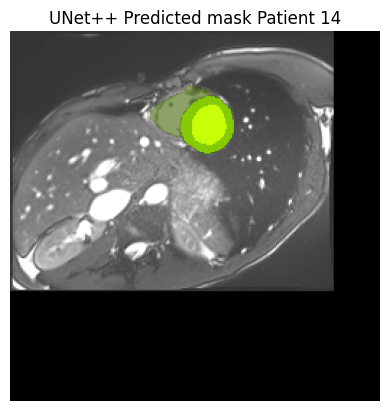

In [51]:
gt_mask = patients_preds[('patient09_gt2', 'frames')][0]
image = patients_preds[('patient09_gt2', 'frames')][1]

fig, axes = plt.subplots()

axes.imshow(np.array(image[:,:,5]),cmap = 'gray')
show_mask(gt_mask[:,:,5], axes, random_color = True)
axes.title.set_text(f"UNet++ Predicted mask Patient 14")
axes.axis("off")

# Use pre processing to create a Dataset

In [53]:
import torch
from torch.utils.data import Dataset, DataLoader

class CardiacDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.data[idx]).float()
        label = torch.from_numpy(self.labels[idx]).long()
        return {'image': image, 'label': label}

# Load the preprocessed data
train_frames = np.load("Train_frames.npy")
train_gt = np.load("Train_gt.npy")

# Create the dataset and dataloader
train_dataset = CardiacDataset(train_frames, train_gt)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the preprocessed validation data
val_frames = np.load("Validation_frames.npy")
val_gt = np.load("Validation_gt.npy")

# Create the validation dataset and dataloader
val_dataset = CardiacDataset(val_frames, val_gt)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Segformer

In [52]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import torch.optim as optim
from torch import nn
from transformers import AutoFeatureExtractor
from itertools import product

In [ ]:
# A metric to assess the overlap between the predicted and ground truth masks
# This is a suggestion, you guys may now what's better for your specific needs
def dice_coefficient(pred, target):
    smooth = 1.0
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth)).item()

In [54]:
# Initialize the model and feature extractor
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

/Users/jamesleon/anaconda3/envs/IA_Verano/lib/python3.11/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning:

The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.



In [ ]:
from torchvision.transforms import Lambda
import torch.nn.functional as F
import csv
import torch.optim as optim
from torch import nn

# Define hyperparameters to tune
learning_rates = [0.001, 0.01]
batch_sizes = [16, 32]
num_epochs = [2, 5]

# Generate all combinations of hyperparameters
hyperparameters = product(learning_rates, batch_sizes, num_epochs)

# Prepare CSV file for saving metrics
csv_file = open('training_metrics.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Learning Rate', 'Batch Size', 'Epoch', 'Step', 'Loss', 'Val Loss'])

# In case you want to add Dice coefficient to CSV headers
# csv_writer.writerow(['Learning Rate', 'Batch Size', 'Epoch', 'Step', 'Loss', 'Dice Coefficient'])


for lr, batch_size, epochs in hyperparameters:
    # Initialize DataLoader with current batch_size
    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize the model and feature extractor
    processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
    
    # Initialize loss function and optimizer with current learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training Loop for current set of hyperparameters
    for epoch in range(epochs):
        model.train()
        for i, batch in enumerate(dataloader):
            images = batch['image']
            labels = batch['label']
            
            # Convert 1-channel images to 3-channel images
            images = images.repeat(1, 3, 1, 1)
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # Extract logits from the outputs
            logits = outputs.logits
            
            #This prints should be added only for debbuging as they may difficult the visualization of the results
            #print(f"labels shape before reshaping: {labels.shape}")
            #print(f"target shape: {[batch_size, height, width]}")

            # Collapse the channel dimension
            labels = labels.max(dim=1)[0]

            # Resize the labels to match the height and width of the logits
            labels = F.interpolate(labels.unsqueeze(1).float(), size=(height, width), mode='nearest').squeeze(1).long()

            # this print should be avoided too unless it is for debbuging
            # Now the labels should have the shape [batch_size, height, width]
            #print(f"labels shape after processing: {labels.shape}")

            # Calculate lossHow 
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            # Calculate Dice coefficient
            # dice = dice_coefficient(predicted.float(), labels.float())
            
            if i % 10 == 0:  # Print and save metrics every 10 batches
                print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], "
                      f"LR: {lr}, Batch Size: {batch_size}, Loss: {loss.item()}")
                csv_writer.writerow([lr, batch_size, epoch+1, i+1, loss.item()])

                # Or if you want to add Dice coefficient to CSV 
                # print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(dataloader)}], "
                #     f"LR: {lr}, Batch Size: {batch_size}, Loss: {loss.item()}, Dice Coefficient: {dice}")
                # csv_writer.writerow([lr, batch_size, epoch+1, i+1, loss.item(), dice])

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_batch in val_dataloader:
                val_images = val_batch['image']
                val_labels = val_batch['label']

                # Convert 1-channel images to 3-channel images
                val_images = val_images.repeat(1, 3, 1, 1)

                val_outputs = model(val_images)
                val_logits = val_outputs.logits

                # Collapse the channel dimension
                val_labels = val_labels.max(dim=1)[0]

                # Resize the labels to match the height and width of the logits
                val_labels = F.interpolate(val_labels.unsqueeze(1).float(), size=(val_logits.size(-2), val_logits.size(-1)), mode='nearest').squeeze(1).long()

                # Calculate loss
                v_loss = criterion(val_logits, val_labels)
                val_loss += v_loss.item()

        val_loss /= len(val_dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Val Loss: {val_loss}")
        csv_writer.writerow([lr, batch_size, epoch+1, 'Val', val_loss])
    
# Close CSV file
csv_file.close()